In [2]:
%matplotlib inline

In [380]:
from brian2 import *
import numpy as np
from time import clock

import json
import codecs

def ld_json(obj, p,encoding="cp1251"):
    with codecs.open(path, "w",encoding=encoding) as f:
        json.dump(obj,f,indent=1,ensure_ascii=0)
        
def ld_json(p,encoding="cp1251"):
    with codecs.open(p,"r",encoding=encoding) as f:
        return json.load(f)

start_scope()

time_per_image = 100*ms
time_step = 0.1*ms
alpha = 30*ms
beta = 500*ms
tau = 10*ms # tau for neuron's voltage 'v'
tau_I = 15*ms # tau for neuron's current 'I'
tau_h = 50*ms # tau for neuron's treshold

lr = 1.
lr_intr = 1.
lr_rec = 1.
wmax = 1.
decay = 0.001

c_inp = 1.
c_intr = 1.
c_out = 1.
c_intr_out = 1.
c_rec = 1.

c_diff = 1.0

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
train :1
'''

eqs_hidden_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
dI_rec/dt = -I_rec/tau_I :1
I = I_inp + I_intr + I_rec: 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_hidden/dt = -hold_hidden/tau_h : 1
train :1
'''

eqs_output_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
I_teacher :1
I = I_inp + I_intr + I_teacher : 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_output/dt = -hold_output/tau_h  : 1
train :1
'''

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-riented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./n_hidden *1*ms/(alpha)
theta_pre += 1./n_hidden *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
w = clip(w + train_pre*(-decay + lr*diff_pre), 0, wmax)
'''

eqs_intrinsic_syn = '''
w: 1
'''

# equations that describe changes if spike of the intr synapse occures
eqs_intrinsic_pre = '''
I_intr_post += w * c_intr
w = clip(w + train_pre*(decay + lr_intr*diff_pre*diff_post), -wmax, 0)
'''

eqs_intrinsic_post = '''
'''

eqs_output_syn = '''
w: 1
w_rec: 1
d: 1
'''

# equations that describe changes if presynaptic spike of the forward synapse of hidden layer occures
eqs_output_pre = '''
a_pre += 1./classes *1*ms/(alpha)
theta_pre += 1./classes *1*ms/(beta)
I_inp_post += w * c_out
'''

# equations that describe changes if postsynaptic spike of the forward synapse of hidden layer occures
eqs_output_post = '''
d = diff_pre
a_post += 1./n_hidden * 1*ms/alpha
theta_post += 1./n_hidden *1*ms/(beta)

I_rec_pre += w_rec * c_rec

w = clip(w + train_pre*(-decay + lr * d), 0, wmax)
w_rec = clip(w_rec + train_post*(-decay + w * 10 * lr_rec *d), 0, wmax)
'''

eqs_intrinsic_output_syn = '''
w: 1
'''

# equations that describe changes if spike of the intr output synapse occures
eqs_intrinsic_output_pre = '''
I_intr_post += w * c_intr_out
w = clip(w + train_pre*(-lr_intr*diff_pre), -wmax, 0)
'''

eqs_intrinsic_output_post = '''
'''

reset_hidden = '''
v = 0
hold_hidden += 0.1*n_hidden
'''

reset_output = '''
v = 0
hold_output += 0.1*classes
'''

class Simulation(object):
    def __init__(self, X, y, n_hidden, inits = None, monitor = None, cheat = False, train = True):
        
        '''
        X - np.array with shape (N samples, N features)
        y - np.array with shape (N samples)
        n_hiiden - number of hidden neurons
        inits  - list of 4 lists that contain 'distribution' and 'condition' parameters 
        for input, intrinsic, output and intrinsic_output connections
            Example: inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j'], 
                     ['equal_[0,1]', 'reciprocal'], ['equal_[-1,0]', 'i!=j']]
        monitor - dictionary with keys 'P', 'G', 'H' or connection names. Each key argument value is 2-d list.
        First one is a list of what parameters to record for the object in the key name and second one is dt.
            Example: monitor = {'H':[['a','I'], 25*ms]}
        cheat - True if you wanna use pretrained model with first layer initialized from some objects of training data
        '''
        self.X = X
        if self.X is not None:
            n_input = int(X.shape[1])
        else:
            raise ValueError('No data provided to the simulation')
        
        self.y = y
        classes = int(len(set(y)))
        if n_hidden:
            pass
        else:
            n_hidden = int(data.shape[1])*classes/100
        
        # list to store initial values for synapses in order [input, intrinsic, output, intrinsic_output]
        if inits:
            pass
        else:
            inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j'], 
                     ['equal_[0,1]', 'reciprocal'], ['equal_[-1,0]', 'i!=j']]
         
        #creatitng the network: groups and synapses
        
        self.P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', 
                             refractory=2*ms, dt = time_step, name='P')
        self.G = NeuronGroup(n_hidden, eqs_hidden_neuron, method=linear, threshold='v > hold_hidden', 
                        reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G')
        self.create_synapse('input_syn', self.P, self.G, eqs_input_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('intrinsic_syn', self.G, self.G, eqs_intrinsic_syn, 
                            eqs_intrinsic_pre, eqs_intrinsic_post, 
                            distribution=inits[1][0], condition=inits[1][1])
        self.H = NeuronGroup(classes, eqs_output_neuron, method=linear, threshold='v > hold_output', 
                        reset=reset_output, refractory=2*ms, dt=time_step, name = 'H')
        self.create_synapse('output_syn', self.G, self.H, eqs_output_syn, eqs_output_pre, eqs_output_post,
                           distribution=inits[2][0], condition=inits[2][1])
        self.create_synapse('intrinsic_output_syn', self.H, self.H, eqs_intrinsic_output_syn, 
                            eqs_intrinsic_output_pre, eqs_intrinsic_output_post, 
                            distribution=inits[3][0], condition=inits[3][1])
        
        # set random values to a and theta for all groups, set train parameter of the group to 1.
        self.random_init_groups([self.P, self.G, self.H], [1, 1, 1])
        
        # operation to do during simulation every dt 
        self.network_op = NetworkOperation(self.update_func, dt=time_per_image)
        
        # params to give for constructing the simulation
        params = [self.P, self.G, self.H, self.input_syn, self.intrinsic_syn, 
                  self.output_syn, self.intrinsic_output_syn, self.network_op]
        
        self.monitor = monitor
        # adding monitors to the simulation params
        # TO DO: OPTIMIZE!!!!!
        if self.monitor:
            if 'P' in self.monitor.keys():
                self.StateMonitorP = StateMonitor(self.P, self.monitor['P'][0], record=self.monitor['P'][2],
                                                  dt=monitor['P'][1],
                                                  name = 'StateMonitorP')
                params.append(self.StateMonitorP)
            else:
                self.StateMonitorP = None
                
            if 'G' in monitor.keys():
                self.StateMonitorG = StateMonitor(self.G, self.monitor['G'][0], record=self.monitor['G'][2],
                                                  dt=monitor['G'][1],
                                                  name = 'StateMonitorG')
                params.append(self.StateMonitorG)
            else:
                self.StateMonitorG = None
                
            if 'H' in monitor.keys():
                self.StateMonitorH = StateMonitor(self.H, self.monitor['H'][0], record=self.monitor['H'][2], 
                                                  dt=monitor['H'][1],
                                                  name = 'StateMonitorH')
                params.append(self.StateMonitorH)
            else:
                self.StateMonitorH = None
                
            if 'Input_weights' in monitor.keys():
                self.SynapseMonitorInput = StateMonitor(self.input_syn, self.monitor['Input_weights'][0], 
                                                        record=self.monitor['Input_weights'][2],
                                                        dt = monitor['Input_weights'][1],
                                                        name = 'SynapseMonitorInput')
                params.append(self.SynapseMonitorInput)
            else:
                self.SynapseMonitorInput = None
                
            if 'Intrinsic_weights' in monitor.keys():
                self.SynapseMonitorIntrinsic = StateMonitor(self.intrinsic_syn, self.monitor['Intrinsic_weights'][0],
                                                        record=self.monitor['Intrinsic_weights'][2],
                                                        dt = monitor['Intrinsic_weights'][1],
                                                        name = 'SynapseMonitorIntrinsic')
                params.append(self.SynapseMonitorIntrinsic)
            else:
                self.SynapseMonitorIntrinsic = None
                
            if 'Output_weights' in monitor.keys():
                self.SynapseMonitorOutput = StateMonitor(self.output_syn, self.monitor['Output_weights'][0],
                                                        record=self.monitor['Output_weights'][2],
                                                        dt = monitor['Output_weights'][1],
                                                        name = 'SynapseMonitorOutput')
                params.append(self.SynapseMonitorOutput)
            else:
                self.SynapseMonitorOutput = None
                
            if 'Intrinsic_output_weights' in monitor.keys():
                self.SynapseMonitorIntrinsicOutput = StateMonitor(self.intrinsic_output_syn, self.monitor['Intrinsic_output_weights'][0],
                                                        record=self.monitor['Intrinsic_output_weights'][2], 
                                                        dt = monitor['Intrinsic_output_weights'][1],
                                                        name = 'SynapseMonitorIntrinsicOutput')
                params.append(self.SynapseMonitorIntrinsicOutput)
            else:
                self.SynapseMonitorIntrinsicOutput = None
        
        # setting params to the simulation
        self.network = Network(params)
        print ('Network created using:')
        for param in params:
            print ('\t'+param.name + '   dt = '+str(param.clock.dt))
            
        self.shown_labels = [] #list to store shown labels during lifetime of the simulation
        self.predictions = [] #list to store preds during lifetime of the simulation
        self.counter = 0 # counter for shown images during lifetime of the simulation
        self.mod = mod # binary, True if train mod, False for test mod
        self.clocks = [] # clocks list per image to monitor if there are to many params to record and RAM is dying 
        self.clocks.append(0)
        
        # never use this
        if cheat:
            dig_y = y[:int(n_hidden)]
            dig_X = X[:int(n_hidden)]
            for s in np.arange(int(n_hidden)):
                for j in np.arange(int(n_input)):
                    # shape dig_X = (n_hidden, n_input)
                    # shape inp_syn is a vectorizes matrix
                    # W_11 ..... W_n1
                    # ..
                    # W_1m ..... W_nm
                    # n = post length, m = pre length
                    self.input_syn.w[s+j*int(n_hidden)] = dig_X[s][j]
            print ('I used cheat initialisation')
    
    def random_init_groups(self, groups, trains):
        '''
        random inits for a and theta of neuron groups + setting trains for neuron groups
        groups - list of NeuronGroup objects, trains - list of train values (Ex. [1, 1, 1] if all are trainable)'''
        print ()
        for group,tr in zip(groups, trains):
            if tr:
                group.train = np.ones_like(group.train)
                print (group.name + ' ' + str(group.N) + ' trainable')
            else:
                group.train = np.zeros_like(group.train)
                print (group.name + ' non-trainable')
            group.a = np.random.rand(len(group))*0.5
            group.theta = np.random.rand(len(group))*0.5
        print ()
    
    def create_synapse(self, name, pre, post, eqs, on_pre, on_post, distribution = 'equal_[0,1]', condition = None):
        
        '''
        AUTO-creating synapses between pre and post NeuronGroup with name='name'
        eqs, on_pre, on_post -  standart paramtres for Synapses
        distribution - string, initial values for weights
        condition - string, some cpecific conditions for connecting, same as in connect() method for Synapses
        extra value for conditions is 'reciprocal'. Should be used if Synapse object has w_rec reciprocal weights'''
        
        exec('self.'+ name + '= Synapses(pre, post, eqs, on_pre = on_pre, on_post = on_post, dt = time_step)')
        print ('{} -> {}, initial distribution = {}'.format(pre.name, post.name, distribution))
        if condition:
            if condition == 'reciprocal':
                exec('self.'+ name + '.connect()')
            else:
                exec('self.'+ name + ".connect(condition = '" + condition +"')")
        else: 
            exec('self.'+ name + '.connect()')

        if distribution == 'equal_[0,1]':    
            exec('self.' + name +'.w = np.random.random(len(pre)*len(post))')
        if distribution == 'equal_[-1,1]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 0.5) * 2.')
        if distribution == 'equal_[-1,0]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 1.)')  
        if distribution == 'norm':
            exec('self.' + name +'.w = np.random.randn(len(pre)*len(post))')
        if distribution == 'zeros':
            exec('self.' + name +'.w = np.zeros_like(self.' + name +'.w)')     
        if distribution == 'ones':
            exec('self.' + name +'.w = np.ones_like(self.' + name +'.w)')
            
        if condition == 'reciprocal':
                exec('self.' + name +'.w_rec = np.array(self.' + name +'.w).transpose()')

        
    def sample_data(self):
        '''
        Sampling random X vector from X and correspondinf label from y
        '''
        sample = np.random.randint(0, self.X.shape[0])
        self.clocks.append(clock())
        return self.X[sample], self.y[sample]

    def update_func(self):
            
            # active phase
            if self.counter % 2 == 0:
        
                image_sample, label_sample = self.sample_data()
                print ('Processing {} image with label {}'.format(self.counter/2, label_sample))

                self.P.rates = [k*250*Hz for k in image_sample]
                if self.mod:
                    self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                    self.H.I_teacher[int(label_sample)] = 10.0
                # saving shown labels
                self.shown_labels.append(int(label_sample))
            # resting phase
            else:
                self.P.rates = np.zeros_like(self.P.rates)
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                
                # saving predictions
                self.predictions.append(np.argmax(np.mean(self.StateMonitorH.a[:,-int(time_per_image/2.):], axis=1)))
                if self.predictions[-1] == self.shown_labels[-1]:
                    print ('correct')
                else:
                    print ('incorrect')
            self.counter += 1

    def run(self, runtime):
        self.network.run(runtime)
        
    def save_weights(seld, path,encoding="cp1251"):
        print ("сохранение сети в файл", path)
        weights = {}
        weights['Input_weights'] = list(self.input_syn.w)
        weights['Intrinsic_weights'] = list(self.intrinsic_syn.w)
        weights['Output_weights'] = list(self.output_syn.w)
        weights['Reciprocal_weights'] = list(self.output_syn.w_rec)
        weights['Intrinsic_output_weights'] = list(self.intrinsic_output_syn.w)
        
        sv_json(weights, path, encoding=encoding)
    
    def load_weights(self, p,encoding="cp1251"):
        print ("загрузка сети из файла", path)
        weights = ld_json(p, encoding=encoding)
        self.input_syn.w = weights['Input_weights']
        self.intrinsic_syn.w = weights['Intrinsic_weights']
        self.output_syn.w = weights['Output_weights']
        self.output_syn.w_rec = weights['Reciprocal_weights']
        self.intrinsic_output_syn.w = weights['Intrinsic_output_weights']
        
    def plot_clocks(self):
        '''
        Plot values of np.diff(self.clocks) to look of there are some errors during "run". If there 
        are huge picks in the middle of simulation on this graph, than it is likely that there are to 
        much recording variables or neurons in Monitors.
        '''
        figure('plot_clocks')
        plot(np.arange(1, len(self.clocks)), np.diff(self.clocks))
        show()
    
    def plot_H(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for H group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['H'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup are recorded)
        '''
        figure('H', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorH.'+str(m)+'[j], label = str(j))')
            legend(loc='best')
        show()
    
    def plot_G(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for G group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['G'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup are recorded).
        '''
        figure('G', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorG.'+str(m)+'[j], label = str(j))')
            legend(loc='best')
        show()
        
    def plot_weights(self, weights_type, interval, weights_indexes):
        '''
        Plotting weights evolution for 'weights_type' on 'interval' period of time for 'weights_indexes' weights.
        Note that weights_indexes is a sub-list from monitor[$weights_type][2] list (remember if it was 'True', than all weights 
        of this type in this Synapse are recorded)
        '''
        
        if weights_type == 'Input_weights':
            if self.SynapseMonitorInput:
                values = self.SynapseMonitorInput.w
            else:
                raise NameError('There was no record of this synapse')
            values = self.SynapseMonitorInput.w
        elif weights_type == 'Intrinsic_weights':
            if self.SynapseMonitorIntrinsic:
                values = self.SynapseMonitorIntrinsic.w
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Output_weights':
            if self.SynapseMonitorOutput:
                values = self.SynapseMonitorOutput.w
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Reciprocal_weights':
            if self.SynapseMonitorOutput:
                values = self.SynapseMonitorOutput.w_rec
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Intrinsic_output_weights':
            if self.SynapseMonitorIntrinsicOutput:
                values = self.SynapseMonitorIntrinsicOutput.w
            else:
                raise NameError('There was no record of this synapse')
        else:
            raise NameError('Incorrect weights_type')
        
        
        figure(weights_type, figsize=(10, 5))
        title(weights_type)
        for j in weights_indexes:
            plot(interval, values[j], label = str(j))
        legend(loc='best')
        show()
        
    def imshow_forward_weights(self, gr, N, M, n, m):
        '''
        Plotting forward weights of 'gr' NeuronGroup on one figure.
        gr - 'G' or 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        if gr == 'G':
            group1 = self.P
            group2 = self.G
            name = 'imshow_input_weights'
            np_images = np.array(self.input_syn.w)
        elif gr == 'H':
            group1 = self.G
            group2 = self.H
            name = 'imshow_output_weights'
            np_images = np.array(self.output_syn.w)
        else:
            raise NameError('No such group')

        images_shape=[len(group1), len(group2)]
        self.one_image(np_mts=np_images, mts_shape=images_shape, N=N, M=M, n=n, m=m, frame=None,
                       name=name)
        
    def imshow_reciprocal_weights(self, gr, N, M, n, m, delta=False):
        '''
        Plotting reciprocal weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        delta - True if you wanna see difference between forward and reciprocal weights
        '''
        if gr == 'H':
            group1 = self.G
            group2 = self.H
            name = 'imshow_reciprocal_weights'
            np_images = np.array(self.output_syn.w_rec)
        else:
            raise NameError('No such group')
            
        if delta:
            np_images2 = np.array(self.output_syn.w)
            np_images = np_images2 - np_images
            
        images_shape=[len(group1), len(group2)]
        self.one_image(np_mts=np_images, mts_shape=images_shape, N=N, M=M, n=n, m=m, frame=None,
                       name=name)
        
    
    def imshow_intrinsic_weights(self, gr, N, M, n, m):
        '''
        Plotting intrinsic weights of 'gr' NeuronGroup on one figure.
        gr - 'G' or 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        if gr == 'G':
            group = self.G
            z = self.intrinsic_syn.w
        elif gr == 'H':
            group = self.H
            z = self.intrinsic_output_syn.w
        else:
            raise NameError('No such group')
        
        for i in np.arange(int(len(group))):
            z = insert(z, i+int(len(group))*i, 0)
    
        np_mts = np.array(z)
        mts_shape=[len(group), len(group)]
        
        self.one_image(np_mts=np_mts, mts_shape=mts_shape, N=N, M=M, n=n, m=m, intrinsic=True, 
                       name='imshow_intrinsic_weights')
        
    def one_image(self, np_mts, mts_shape, N, M, n, m, frame=None, intrinsic=False, name=None):
        '''
        Plotting image of np_mts frame
        np_mts - numpy array of multivariate timeseries (or just numpy array for fixed frame)
        mts_shape - list [amount of neurons in pre group, amount of neurons in post group]
        frame - frame of timeseries, None if np_mts is just numpy array of weights instead of synapse monitor
        N, M - height and width of figure in "subplots"
        n, m - height and width of weight image
        intrinsic - True if visualising intrinsic weights
        name - unique name of the figure
        '''
        if intrinsic:
            images = np.array(np_mts).reshape(int(mts_shape[1]), int(n), int(m))
        else:
            images = [[np_mts[r + j * int(mts_shape[1])][frame]
                        for j in np.arange(mts_shape[0])] 
                        for r in np.arange(mts_shape[1])]
            images = np.array(images).reshape(int(mts_shape[1]), int(n), int(m))

        horizontal_lines = np.ones((1, M*(m+1)+1))*(np.nan)

        for i in np.arange(N):
            horizontal_line = np.ones((images[0].shape[0],1))*(np.nan)
            for j in np.arange(M):
                im = np.hstack((images[int(j+i*M)],np.ones((images[int(j+i*M)].shape[0],1))*(np.nan)))
                horizontal_line = np.hstack((horizontal_line, im))
            horizontal_line = np.vstack((horizontal_line, np.ones((1, M*(m+1)+1))*(np.nan)))
            horizontal_lines = np.vstack((horizontal_lines, horizontal_line))

        figure(name, figsize=(4, 4*N/M))
        title(name)
        imshow(horizontal_lines, interpolation=None, cmap='winter')
        colorbar()
        axis('off')
        show()

In [381]:
def create_dataset(num = 1000, shape = [28, 28], classes = 2):
    X = np.zeros((num, shape[0], shape[1]))
    y = np.zeros(num)
    for i in np.arange(X.shape[0]):
        decision = np.random.randint(0, classes)
        y[i] = decision
        start_x = 0
        start_y = decision
        for j in np.arange(shape[0]):
            X[i][np.clip(start_x+j, 0, shape[0]-1)][start_y] = 1.0
    
    return X.reshape(-1, shape[0]*shape[1]), y

In [382]:
X, y = create_dataset(1000, [4,4], 2)

In [383]:
inits = None #wanns use default, chosen inside of the __init__ method
monitor = {} # dict with names of objects to record and their parameters
monitor['G'] = [['a','I_inp', 'I_intr', 'I_rec'], 1*ms, True]
monitor['H'] = [['a','I_inp', 'I_intr', 'I'], 1*ms, True]
monitor['Input_weights'] = [['w'], 25*ms, True]
monitor['Intrinsic_weights'] = [['w'], 25*ms, True]
monitor['Output_weights'] = [['w','w_rec'], 25*ms, True]
monitor['Intrinsic_output_weights'] = [['w'], 25*ms, True]

n_hidden = 10
classes = int(len(set(y)))

NN = Simulation(X, y, n_hidden=n_hidden, inits=inits, monitor=monitor)

P -> G, initial distribution = equal_[0,1]
G -> G, initial distribution = equal_[-1,0]
G -> H, initial distribution = equal_[0,1]
H -> H, initial distribution = equal_[-1,0]

P 16 trainable
G 10 trainable
H 2 trainable

Network created using:
	P   dt = 100. us
	G   dt = 100. us
	H   dt = 100. us
	synapses_6   dt = 100. us
	synapses_7   dt = 100. us
	synapses_10   dt = 100. us
	synapses_11   dt = 100. us
	networkoperation_2   dt = 100. ms
	StateMonitorG   dt = 1. ms
	StateMonitorH   dt = 1. ms
	SynapseMonitorInput   dt = 25. ms
	SynapseMonitorIntrinsic   dt = 25. ms
	SynapseMonitorOutput   dt = 25. ms
	SynapseMonitorIntrinsicOutput   dt = 25. ms


In [384]:
NN.run(10000*ms)

Processing 0.0 image with label 0.0
correct
Processing 1.0 image with label 0.0
correct
Processing 2.0 image with label 0.0
correct
Processing 3.0 image with label 0.0
correct
Processing 4.0 image with label 1.0
incorrect
Processing 5.0 image with label 1.0
incorrect
Processing 6.0 image with label 0.0
correct
Processing 7.0 image with label 0.0
correct
Processing 8.0 image with label 1.0
incorrect
Processing 9.0 image with label 1.0
incorrect
Processing 10.0 image with label 0.0
correct
Processing 11.0 image with label 0.0
correct
Processing 12.0 image with label 0.0
correct
Processing 13.0 image with label 1.0
incorrect
Processing 14.0 image with label 0.0
correct
Processing 15.0 image with label 0.0
correct
Processing 16.0 image with label 0.0
correct
Processing 17.0 image with label 0.0
correct
Processing 18.0 image with label 1.0
incorrect
Processing 19.0 image with label 0.0
correct
Processing 20.0 image with label 0.0
correct
Processing 21.0 image with label 1.0
incorrect
Proces

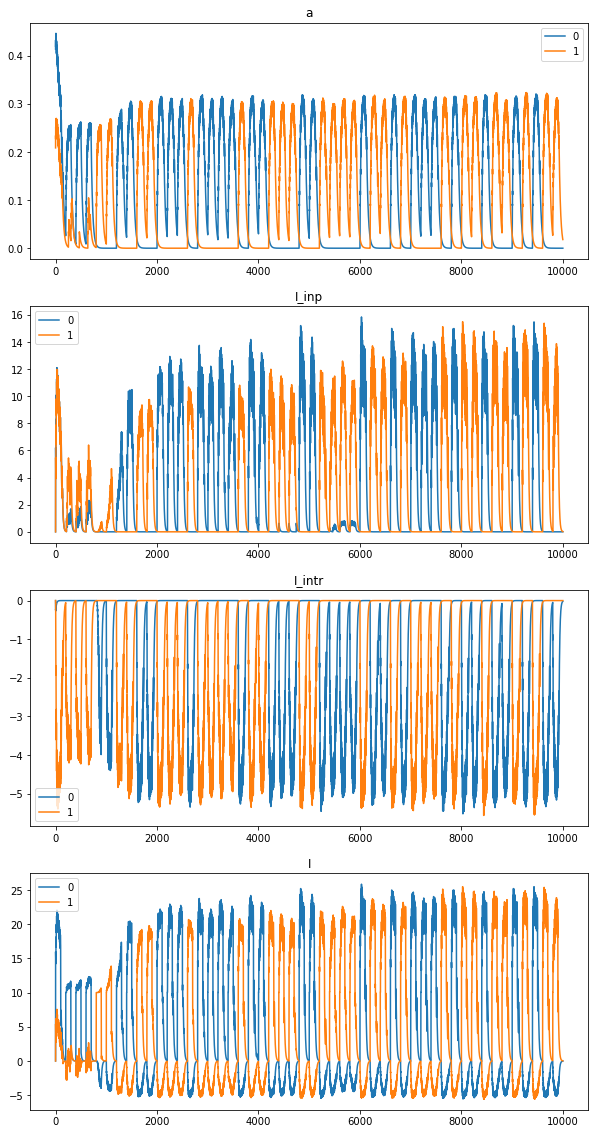

In [385]:
NN.plot_H(monitor['H'][0], NN.StateMonitorH.t/ms, np.arange(len(NN.H)))

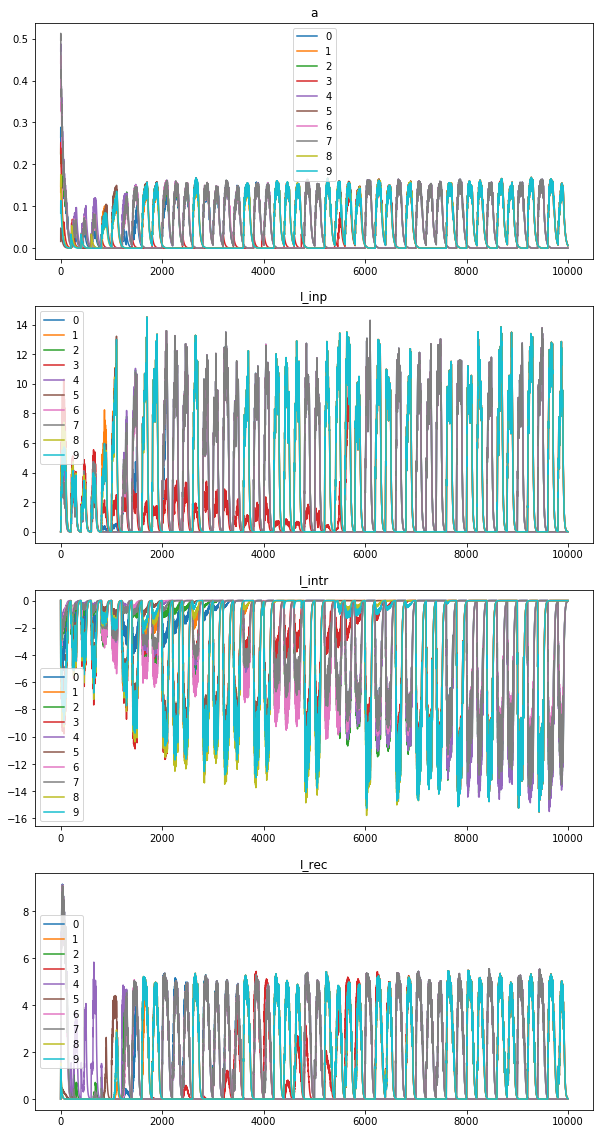

In [386]:
NN.plot_G(monitor['G'][0], NN.StateMonitorG.t/ms, np.arange(len(NN.G)))

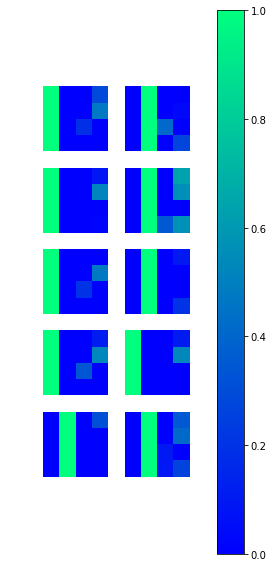

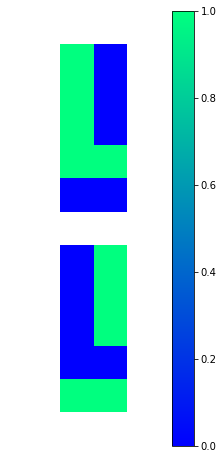

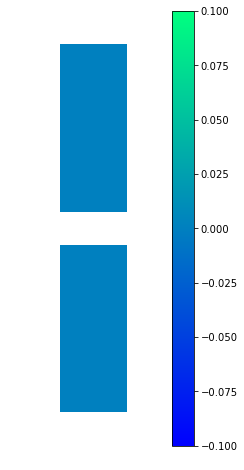

In [387]:
NN.imshow_forward_weights('G', 5, 2, 4, 4)
NN.imshow_forward_weights('H', 2, 1, 5, 2)
NN.imshow_reciprocal_weights('H', 2, 1, 5, 2, delta=True)

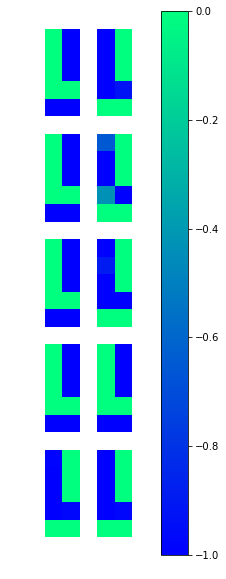

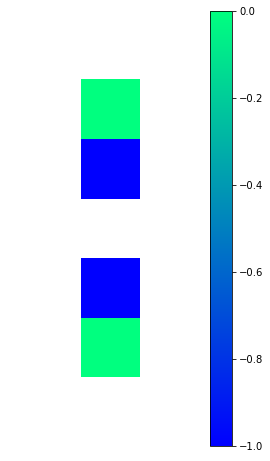

In [388]:
NN.imshow_intrinsic_weights('G', 5, 2, 5, 2)
NN.imshow_intrinsic_weights('H', 2, 1, 2, 1)

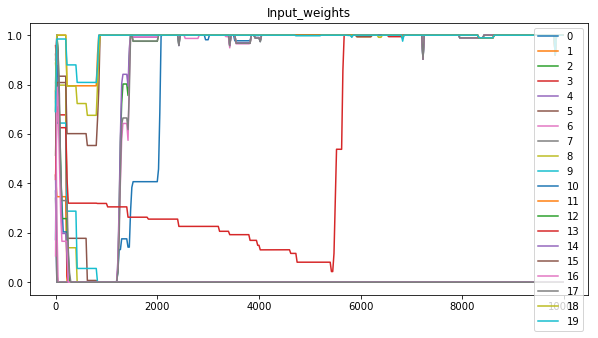

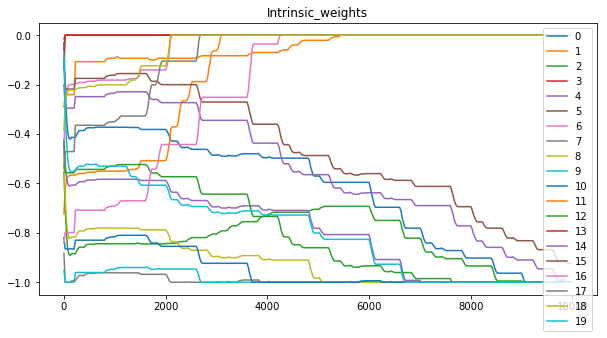

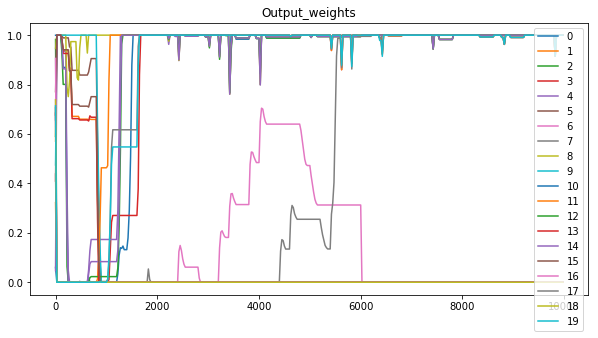

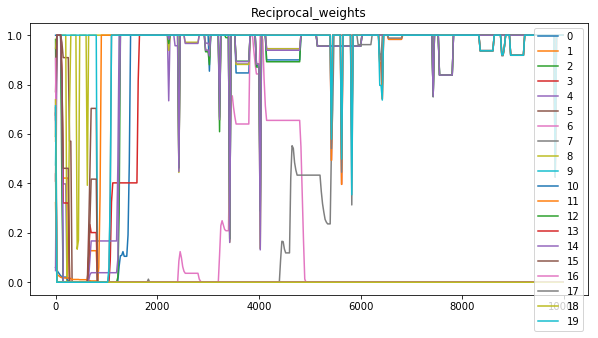

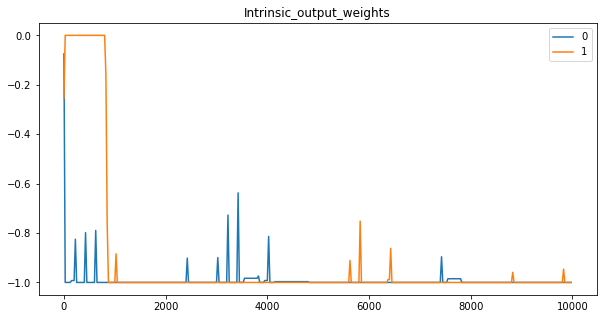

In [390]:
NN.plot_weights('Input_weights',NN.SynapseMonitorInput.t/ms, np.arange(20))
NN.plot_weights('Intrinsic_weights',NN.SynapseMonitorIntrinsic.t/ms, np.arange(20))
NN.plot_weights('Output_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.output_syn)))
NN.plot_weights('Reciprocal_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.output_syn)))
NN.plot_weights('Intrinsic_output_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.H)))